# Evaluation of DiADM Script

- Show some visual examples of DiADM 
- Calculate Memorization Rate
- Calculate Consistency According to Classifier

In [1]:
import os
from utils import dict_to_json

autoguidance=False
guidance=1.0
model_weights="/vol/ideadata/ed52egek/pycharm/trichotomy/importantmodels/cxr8_diffusionmodels/baseline-runs/cxr8_pseudocond/training-state-0100663.pt"
gmodel_weights="/vol/ideadata/ed52egek/pycharm/trichotomy/importantmodels/cxr8_diffusionmodels/baseline-runs/cxr8_pseudocond/training-state-0008388.pt"
path_net="/vol/ideadata/ed52egek/pycharm/trichotomy/importantmodels/cxr8_diffusionmodels/baseline-runs/cxr8_pseudocond/network-snapshot-0100663-0.100.pkl"
path_gnet="/vol/ideadata/ed52egek/pycharm/trichotomy/importantmodels/cxr8_diffusionmodels/baseline-runs/cxr8_pseudocond/network-snapshot-0008388-0.050.pkl"
outdir="./diadm_res/eval_100k_pscguid"


default_kwargs = {
    "DiADM":{
        "autoguidance":autoguidance,
        "guidance":guidance,
        "filelist":"/vol/ideadata/ed52egek/pycharm/trichotomy/datasets/eight_cxr8_train.txt",
        "model_kwargs":{
            "model_weights":model_weights, 
            "gmodel_weights":gmodel_weights,
            "path_net":path_net,
            "path_gnet":path_gnet,
            "name":"DiADM",
        },
        "ds_kwargs":{
            "cond_mode":"pseudocond", # pseudocond, cond
            "basedir":"/vol/idea_ramses/ed52egek/data/trichotomy",
            "basedir_images":"/vol/ideadata/ed52egek/data/chestxray14"
        }
    },
}

os.makedirs(outdir, exist_ok=True)
dict_to_json(outdir, os.path.join(outdir, "settings.json"))

In [2]:
from generate_syn_train import get_image_generation_model, edm_sampler
from src.diffusion.generation import ImageIterableDSE
from edm2.training.dataset import LatentDataset
from tqdm import tqdm
import numpy as np

mode = list(default_kwargs.keys())[0]
model_kwargs = default_kwargs[mode]["model_kwargs"]
ds_kwargs = default_kwargs[mode]["ds_kwargs"]

net, gnet, encoder =  get_image_generation_model(**model_kwargs)

train_ds = LatentDataset(filelist_txt=default_kwargs[mode]["filelist"], load_to_memory=False, basedir=ds_kwargs["basedir"], cond_mode=ds_kwargs["cond_mode"])


Loading network from /vol/ideadata/ed52egek/pycharm/trichotomy/importantmodels/cxr8_diffusionmodels/baseline-runs/cxr8_pseudocond/network-snapshot-0100663-0.100.pkl ...


/vol/ideadata/ed52egek/pycharm/trichotomy/generate_syn_train.py:182: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_weights)["net"])


Encoder was initilized with {'vae_name': 'stabilityai/stable-diffusion-2', 'encoder_norm_mode': 'cxr8'}
Loading guidance network from /vol/ideadata/ed52egek/pycharm/trichotomy/importantmodels/cxr8_diffusionmodels/baseline-runs/cxr8_pseudocond/network-snapshot-0008388-0.050.pkl ...


/vol/ideadata/ed52egek/pycharm/trichotomy/generate_syn_train.py:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gnet.load_state_dict(torch.load(gmodel_weights)["net"])


Setting up StabilityVAEEncoder...


/vol/ideadata/ed52egek/miniconda/envs/trichotomy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/vol/ideadata/ed52egek/pycharm/trichotomy/edm2/training/dataset.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization

In [3]:
import matplotlib.pyplot as plt
import torch

def viz_pred_with_border(images, memorization_preds, consistency_score, border_width=5, safe_name="out.pdf"):
    # creates visualization that shows similary and memorization prediction for a few samples
    for i in range(len(images)):
        if i == 0: 
            border_color = torch.tensor([1, 1, 1])
            bw = border_width + 10
        else: 
            border_color = torch.tensor([1, 0, 0]) if memorization_preds[i] else torch.tensor([0, 1, 0])
            bw = border_width

        images[i, :, :bw, :] = border_color[:, None, None]  # Top
        images[i, :, -bw:, :] = border_color[:, None, None]  # Bottom
        images[i, :, :, :bw] = border_color[:, None, None]  # Left
        images[i, :, :, -bw:] = border_color[:, None, None]  # Right

    image = torch.cat([im for im in images], dim=-1)
    image_np = image.permute(1, 2, 0).cpu().numpy() 

    fig, ax = plt.subplots(figsize=(10, 5))  # Adjust figure size
    ax.imshow(image_np)
    ax.axis("off")  # Hide axes

    # Add consistency scores as text in bottom-right corners
    img_width = images.shape[-1]
    num_images = len(images)
    for i in range(1, num_images):  # Skipping the first image
        x_pos = img_width * (i+1) - 40  # Adjust position for each image
        y_pos = images.shape[1] - 10  # Bottom padding
        ax.text(x_pos, y_pos, f"{consistency_score[i-1]:.2f}", 
                color="white", fontsize=12, ha="right", va="bottom", 
                bbox=dict(facecolor="black", alpha=0.5, edgecolor="none", boxstyle="round,pad=0.3"))

    plt.savefig(safe_name, bbox_inches="tight")
    plt.savefig(safe_name)
    return True


/vol/ideadata/ed52egek/miniconda/envs/trichotomy/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/vol/ideadata/ed52egek/miniconda/envs/trichotomy/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/vol/ideadata/ed52egek/pycharm/trichotomy/src/dse.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpick

Memorization Rate images/00000001_000.png: 0.8125


Generating images:   1%|          | 1/120 [00:30<1:00:45, 30.63s/batch]/vol/ideadata/ed52egek/pycharm/trichotomy/edm2/training/dataset.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experime

Memorization Rate images/00000001_001.png: 0.9375


Generating images:   2%|▏         | 2/120 [00:39<35:34, 18.09s/batch]  /vol/ideadata/ed52egek/pycharm/trichotomy/edm2/training/dataset.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experime

Memorization Rate images/00000002_000.png: 1.0
only memorized for guidance: 1.4 and path: images/00000002_000.png
Memorization Rate images/00000002_000.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000002_000.png
Memorization Rate images/00000002_000.png: 1.0
only memorized for guidance: 1.1999999999999997 and path: images/00000002_000.png
Memorization Rate images/00000002_000.png: 0.9375


Generating images:   2%|▎         | 3/120 [01:02<38:50, 19.92s/batch]/vol/ideadata/ed52egek/pycharm/trichotomy/edm2/training/dataset.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

Memorization Rate images/00000005_000.png: 1.0
only memorized for guidance: 1.4 and path: images/00000005_000.png
Memorization Rate images/00000005_000.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000005_000.png
Memorization Rate images/00000005_000.png: 1.0
only memorized for guidance: 1.1999999999999997 and path: images/00000005_000.png
Memorization Rate images/00000005_000.png: 1.0
only memorized for guidance: 1.0999999999999996 and path: images/00000005_000.png
Memorization Rate images/00000005_000.png: 0.875


Generating images:   3%|▎         | 4/120 [01:29<44:00, 22.77s/batch]

Memorization Rate images/00000005_001.png: 0.875


Generating images:   4%|▍         | 5/120 [01:34<31:47, 16.59s/batch]

Memorization Rate images/00000005_002.png: 1.0
only memorized for guidance: 1.4 and path: images/00000005_002.png
Memorization Rate images/00000005_002.png: 0.8125


Generating images:   5%|▌         | 6/120 [01:45<27:53, 14.68s/batch]

Memorization Rate images/00000005_003.png: 1.0
only memorized for guidance: 1.4 and path: images/00000005_003.png


Generating images:   6%|▌         | 7/120 [01:56<25:17, 13.43s/batch]

Memorization Rate images/00000005_003.png: 0.9375
Memorization Rate images/00000005_004.png: 1.0
only memorized for guidance: 1.4 and path: images/00000005_004.png
Memorization Rate images/00000005_004.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000005_004.png
Memorization Rate images/00000005_004.png: 1.0
only memorized for guidance: 1.1999999999999997 and path: images/00000005_004.png


Generating images:   7%|▋         | 8/120 [02:18<29:55, 16.03s/batch]

Memorization Rate images/00000005_004.png: 0.9375
Memorization Rate images/00000005_005.png: 0.8125


Generating images:   8%|▊         | 9/120 [02:23<23:40, 12.80s/batch]

Memorization Rate images/00000005_007.png: 1.0
only memorized for guidance: 1.4 and path: images/00000005_007.png
Memorization Rate images/00000005_007.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000005_007.png


Generating images:   8%|▊         | 10/120 [02:40<25:28, 13.89s/batch]

Memorization Rate images/00000005_007.png: 0.9375
Memorization Rate images/00000007_000.png: 0.8125


Generating images:   9%|▉         | 11/120 [02:45<20:40, 11.38s/batch]

Memorization Rate images/00000008_000.png: 1.0
only memorized for guidance: 1.4 and path: images/00000008_000.png
Memorization Rate images/00000008_000.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000008_000.png
Memorization Rate images/00000008_000.png: 1.0
only memorized for guidance: 1.1999999999999997 and path: images/00000008_000.png


Generating images:  10%|█         | 12/120 [03:07<26:10, 14.54s/batch]

Memorization Rate images/00000008_000.png: 0.9375
Memorization Rate images/00000008_001.png: 1.0
only memorized for guidance: 1.4 and path: images/00000008_001.png
Memorization Rate images/00000008_001.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000008_001.png
Memorization Rate images/00000008_001.png: 0.875


Generating images:  11%|█         | 13/120 [03:24<27:00, 15.14s/batch]

Memorization Rate images/00000012_000.png: 1.0
only memorized for guidance: 1.4 and path: images/00000012_000.png
Memorization Rate images/00000012_000.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000012_000.png
Memorization Rate images/00000012_000.png: 1.0
only memorized for guidance: 1.1999999999999997 and path: images/00000012_000.png
Memorization Rate images/00000012_000.png: 1.0
only memorized for guidance: 1.0999999999999996 and path: images/00000012_000.png


Generating images:  12%|█▏        | 14/120 [03:51<33:10, 18.78s/batch]

Memorization Rate images/00000012_000.png: 0.9375
Memorization Rate images/00000013_023.png: 0.5625


Generating images:  13%|█▎        | 16/120 [04:02<20:52, 12.05s/batch]

Memorization Rate images/00000013_025.png: 0.9375
Memorization Rate images/00000013_026.png: 0.5625


Generating images:  14%|█▍        | 17/120 [04:08<17:24, 10.14s/batch]

Memorization Rate images/00000013_032.png: 0.8125


Generating images:  15%|█▌        | 18/120 [04:14<14:58,  8.81s/batch]

Memorization Rate images/00000013_033.png: 0.8125


Generating images:  16%|█▌        | 19/120 [04:19<13:15,  7.87s/batch]

Memorization Rate images/00000013_034.png: 1.0
only memorized for guidance: 1.4 and path: images/00000013_034.png
Memorization Rate images/00000013_034.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000013_034.png


Generating images:  17%|█▋        | 20/120 [04:36<17:23, 10.43s/batch]

Memorization Rate images/00000013_034.png: 0.9375
Memorization Rate images/00000013_036.png: 0.8125


Generating images:  18%|█▊        | 22/120 [04:47<13:09,  8.06s/batch]

Memorization Rate images/00000013_038.png: 0.9375
Memorization Rate images/00000013_039.png: 0.875


Generating images:  20%|██        | 24/120 [04:59<10:54,  6.81s/batch]

Memorization Rate images/00000013_044.png: 0.9375
Memorization Rate images/00000013_045.png: 0.875


Generating images:  21%|██        | 25/120 [05:04<10:15,  6.48s/batch]

Memorization Rate images/00000013_000.png: 0.6875


Generating images:  22%|██▏       | 26/120 [05:10<09:47,  6.25s/batch]

Memorization Rate images/00000013_001.png: 0.6875


Generating images:  22%|██▎       | 27/120 [05:16<09:26,  6.09s/batch]

Memorization Rate images/00000013_002.png: 0.75


Generating images:  23%|██▎       | 28/120 [05:21<09:09,  5.97s/batch]

Memorization Rate images/00000013_005.png: 0.5


Generating images:  24%|██▍       | 29/120 [05:27<08:56,  5.90s/batch]

Memorization Rate images/00000013_006.png: 0.75


Generating images:  25%|██▌       | 30/120 [05:33<08:44,  5.83s/batch]

Memorization Rate images/00000013_008.png: 0.875


Generating images:  26%|██▌       | 31/120 [05:38<08:35,  5.79s/batch]

Memorization Rate images/00000013_011.png: 0.5625


Generating images:  27%|██▋       | 32/120 [05:44<08:27,  5.77s/batch]

Memorization Rate images/00000013_012.png: 0.8125


Generating images:  28%|██▊       | 33/120 [05:50<08:28,  5.85s/batch]

Memorization Rate images/00000013_013.png: 0.6875


Generating images:  28%|██▊       | 34/120 [05:56<08:19,  5.81s/batch]

Memorization Rate images/00000013_014.png: 0.625


Generating images:  30%|███       | 36/120 [06:07<08:00,  5.72s/batch]

Memorization Rate images/00000013_015.png: 0.9375
Memorization Rate images/00000013_016.png: 0.625


Generating images:  31%|███       | 37/120 [06:13<07:54,  5.72s/batch]

Memorization Rate images/00000013_020.png: 1.0
only memorized for guidance: 1.4 and path: images/00000013_020.png
Memorization Rate images/00000013_020.png: 0.875


Generating images:  32%|███▏      | 38/120 [06:24<10:02,  7.35s/batch]

Memorization Rate images/00000013_021.png: 0.8125


Generating images:  32%|███▎      | 39/120 [06:30<09:15,  6.86s/batch]

Memorization Rate images/00000017_000.png: 0.8125


Generating images:  33%|███▎      | 40/120 [06:35<08:41,  6.52s/batch]

Memorization Rate images/00000023_002.png: 1.0
only memorized for guidance: 1.4 and path: images/00000023_002.png
Memorization Rate images/00000023_002.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000023_002.png
Memorization Rate images/00000023_002.png: 1.0
only memorized for guidance: 1.1999999999999997 and path: images/00000023_002.png
Memorization Rate images/00000023_002.png: 1.0
only memorized for guidance: 1.0999999999999996 and path: images/00000023_002.png
Memorization Rate images/00000023_002.png: 1.0
only memorized for guidance: 0.9999999999999997 and path: images/00000023_002.png
Memorization Rate images/00000023_002.png: 1.0
only memorized for guidance: 0.8999999999999997 and path: images/00000023_002.png


Generating images:  34%|███▍      | 41/120 [07:14<21:12, 16.11s/batch]

Memorization Rate images/00000023_002.png: 0.9375
Memorization Rate images/00000030_000.png: 1.0
only memorized for guidance: 1.4 and path: images/00000030_000.png


Generating images:  35%|███▌      | 42/120 [07:25<19:01, 14.63s/batch]

Memorization Rate images/00000030_000.png: 0.9375
Memorization Rate images/00000030_001.png: 1.0
only memorized for guidance: 1.4 and path: images/00000030_001.png
Memorization Rate images/00000030_001.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000030_001.png
Memorization Rate images/00000030_001.png: 1.0
only memorized for guidance: 1.1999999999999997 and path: images/00000030_001.png
Memorization Rate images/00000030_001.png: 1.0
only memorized for guidance: 1.0999999999999996 and path: images/00000030_001.png
Memorization Rate images/00000030_001.png: 1.0
only memorized for guidance: 0.9999999999999997 and path: images/00000030_001.png
Memorization Rate images/00000030_001.png: 1.0
only memorized for guidance: 0.8999999999999997 and path: images/00000030_001.png
Memorization Rate images/00000030_001.png: 0.8125


Generating images:  36%|███▌      | 43/120 [08:04<27:55, 21.76s/batch]

Memorization Rate images/00000032_000.png: 0.75


Generating images:  37%|███▋      | 44/120 [08:09<21:28, 16.95s/batch]

Memorization Rate images/00000032_016.png: 0.75


Generating images:  38%|███▊      | 45/120 [08:15<17:02, 13.63s/batch]

Memorization Rate images/00000032_021.png: 0.8125


Generating images:  38%|███▊      | 46/120 [08:21<13:53, 11.26s/batch]

Memorization Rate images/00000032_023.png: 1.0
only memorized for guidance: 1.4 and path: images/00000032_023.png


Generating images:  39%|███▉      | 47/120 [08:32<13:45, 11.31s/batch]

Memorization Rate images/00000032_023.png: 0.9375
Memorization Rate images/00000032_024.png: 0.5625


Generating images:  40%|████      | 48/120 [08:38<11:33,  9.63s/batch]

Memorization Rate images/00000032_028.png: 0.3125


Generating images:  41%|████      | 49/120 [08:44<10:00,  8.46s/batch]

Memorization Rate images/00000032_029.png: 0.6875


Generating images:  42%|████▏     | 50/120 [08:50<08:55,  7.65s/batch]

Memorization Rate images/00000032_031.png: 0.5625


Generating images:  42%|████▎     | 51/120 [08:55<08:07,  7.07s/batch]

Memorization Rate images/00000032_038.png: 0.6875


Generating images:  43%|████▎     | 52/120 [09:01<07:33,  6.67s/batch]

Memorization Rate images/00000032_043.png: 0.8125


Generating images:  44%|████▍     | 53/120 [09:07<07:07,  6.38s/batch]

Memorization Rate images/00000032_053.png: 0.875


Generating images:  45%|████▌     | 54/120 [09:12<06:48,  6.19s/batch]

Memorization Rate images/00000032_054.png: 1.0
only memorized for guidance: 1.4 and path: images/00000032_054.png


Generating images:  46%|████▌     | 55/120 [09:23<08:16,  7.64s/batch]

Memorization Rate images/00000032_054.png: 0.9375
Memorization Rate images/00000032_055.png: 0.8125


Generating images:  48%|████▊     | 57/120 [09:35<07:00,  6.68s/batch]

Memorization Rate images/00000032_056.png: 0.9375
Memorization Rate images/00000036_000.png: 0.75


Generating images:  49%|████▉     | 59/120 [09:46<06:15,  6.15s/batch]

Memorization Rate images/00000038_001.png: 0.9375
Memorization Rate images/00000038_006.png: 0.75


Generating images:  50%|█████     | 60/120 [09:52<06:01,  6.02s/batch]

Memorization Rate images/00000039_004.png: 1.0
only memorized for guidance: 1.4 and path: images/00000039_004.png


Generating images:  51%|█████     | 61/120 [10:03<07:23,  7.52s/batch]

Memorization Rate images/00000039_004.png: 0.9375
Memorization Rate images/00000053_001.png: 0.625


Generating images:  52%|█████▎    | 63/120 [10:14<06:13,  6.56s/batch]

Memorization Rate images/00000056_000.png: 0.9375
Memorization Rate images/00000056_001.png: 1.0
only memorized for guidance: 1.4 and path: images/00000056_001.png
Memorization Rate images/00000056_001.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000056_001.png
Memorization Rate images/00000056_001.png: 1.0
only memorized for guidance: 1.1999999999999997 and path: images/00000056_001.png
Memorization Rate images/00000056_001.png: 1.0
only memorized for guidance: 1.0999999999999996 and path: images/00000056_001.png


Generating images:  53%|█████▎    | 64/120 [10:42<11:57, 12.81s/batch]

Memorization Rate images/00000056_001.png: 0.9375
Memorization Rate images/00000058_000.png: 1.0
only memorized for guidance: 1.4 and path: images/00000058_000.png
Memorization Rate images/00000058_000.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000058_000.png
Memorization Rate images/00000058_000.png: 1.0
only memorized for guidance: 1.1999999999999997 and path: images/00000058_000.png


Generating images:  54%|█████▍    | 65/120 [11:04<14:14, 15.54s/batch]

Memorization Rate images/00000058_000.png: 0.9375


Generating images:  55%|█████▌    | 66/120 [11:09<11:20, 12.60s/batch]

Memorization Rate images/00000060_000.png: 0.9375
Memorization Rate images/00000061_002.png: 1.0
only memorized for guidance: 1.4 and path: images/00000061_002.png
Memorization Rate images/00000061_002.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000061_002.png


Generating images:  56%|█████▌    | 67/120 [11:26<12:09, 13.76s/batch]

Memorization Rate images/00000061_002.png: 0.9375
Memorization Rate images/00000061_003.png: 1.0
only memorized for guidance: 1.4 and path: images/00000061_003.png


Generating images:  57%|█████▋    | 68/120 [11:37<11:17, 13.03s/batch]

Memorization Rate images/00000061_003.png: 0.9375
Memorization Rate images/00000061_005.png: 1.0
only memorized for guidance: 1.4 and path: images/00000061_005.png
Memorization Rate images/00000061_005.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000061_005.png
Memorization Rate images/00000061_005.png: 0.875


Generating images:  57%|█████▊    | 69/120 [11:54<12:02, 14.17s/batch]

Memorization Rate images/00000061_006.png: 1.0
only memorized for guidance: 1.4 and path: images/00000061_006.png
Memorization Rate images/00000061_006.png: 0.875


Generating images:  58%|█████▊    | 70/120 [12:05<11:03, 13.27s/batch]

Memorization Rate images/00000061_007.png: 0.875


Generating images:  59%|█████▉    | 71/120 [12:11<08:59, 11.01s/batch]

Memorization Rate images/00000061_008.png: 1.0
only memorized for guidance: 1.4 and path: images/00000061_008.png
Memorization Rate images/00000061_008.png: 0.8125


Generating images:  60%|██████    | 72/120 [12:22<08:50, 11.05s/batch]

Memorization Rate images/00000061_015.png: 1.0
only memorized for guidance: 1.4 and path: images/00000061_015.png
Memorization Rate images/00000061_015.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000061_015.png


Generating images:  61%|██████    | 73/120 [12:39<09:59, 12.75s/batch]

Memorization Rate images/00000061_015.png: 0.9375
Memorization Rate images/00000066_000.png: 1.0
only memorized for guidance: 1.4 and path: images/00000066_000.png


Generating images:  62%|██████▏   | 74/120 [12:50<09:22, 12.23s/batch]

Memorization Rate images/00000066_000.png: 0.9375
Memorization Rate images/00000071_001.png: 1.0
only memorized for guidance: 1.4 and path: images/00000071_001.png
Memorization Rate images/00000071_001.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000071_001.png
Memorization Rate images/00000071_001.png: 1.0
only memorized for guidance: 1.1999999999999997 and path: images/00000071_001.png
Memorization Rate images/00000071_001.png: 1.0
only memorized for guidance: 1.0999999999999996 and path: images/00000071_001.png
Memorization Rate images/00000071_001.png: 1.0
only memorized for guidance: 0.9999999999999997 and path: images/00000071_001.png


Generating images:  62%|██████▎   | 75/120 [13:23<13:51, 18.48s/batch]

Memorization Rate images/00000071_001.png: 0.9375
Memorization Rate images/00000080_001.png: 1.0
only memorized for guidance: 1.4 and path: images/00000080_001.png
Memorization Rate images/00000080_001.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000080_001.png


Generating images:  63%|██████▎   | 76/120 [13:39<13:06, 17.88s/batch]

Memorization Rate images/00000080_001.png: 0.9375
Memorization Rate images/00000080_004.png: 1.0
only memorized for guidance: 1.4 and path: images/00000080_004.png
Memorization Rate images/00000080_004.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000080_004.png


Generating images:  64%|██████▍   | 77/120 [13:56<12:30, 17.45s/batch]

Memorization Rate images/00000080_004.png: 0.9375
Memorization Rate images/00000086_002.png: 0.8125


Generating images:  65%|██████▌   | 78/120 [14:02<09:45, 13.94s/batch]

Memorization Rate images/00000090_009.png: 0.8125


Generating images:  66%|██████▌   | 79/120 [14:07<07:52, 11.52s/batch]

Memorization Rate images/00000091_008.png: 0.8125


Generating images:  67%|██████▋   | 80/120 [14:13<06:32,  9.82s/batch]

Memorization Rate images/00000091_010.png: 0.625


Generating images:  68%|██████▊   | 82/120 [14:25<04:52,  7.68s/batch]

Memorization Rate images/00000103_010.png: 0.9375


Generating images:  69%|██████▉   | 83/120 [14:30<04:20,  7.05s/batch]

Memorization Rate images/00000112_002.png: 0.9375
Memorization Rate images/00000116_014.png: 0.6875


Generating images:  70%|███████   | 84/120 [14:36<03:59,  6.66s/batch]

Memorization Rate images/00000116_015.png: 0.75


Generating images:  71%|███████   | 85/120 [14:42<03:43,  6.38s/batch]

Memorization Rate images/00000116_019.png: 0.6875


Generating images:  72%|███████▎  | 87/120 [14:53<03:17,  6.00s/batch]

Memorization Rate images/00000132_002.png: 0.9375
Memorization Rate images/00000165_001.png: 1.0
only memorized for guidance: 1.4 and path: images/00000165_001.png
Memorization Rate images/00000165_001.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000165_001.png
Memorization Rate images/00000165_001.png: 1.0
only memorized for guidance: 1.1999999999999997 and path: images/00000165_001.png
Memorization Rate images/00000165_001.png: 1.0
only memorized for guidance: 1.0999999999999996 and path: images/00000165_001.png
Memorization Rate images/00000165_001.png: 1.0
only memorized for guidance: 0.9999999999999997 and path: images/00000165_001.png
Memorization Rate images/00000165_001.png: 1.0
only memorized for guidance: 0.8999999999999997 and path: images/00000165_001.png
Memorization Rate images/00000165_001.png: 0.875


Generating images:  73%|███████▎  | 88/120 [15:32<08:25, 15.80s/batch]

Memorization Rate images/00000181_013.png: 0.625


Generating images:  74%|███████▍  | 89/120 [15:37<06:36, 12.78s/batch]

Memorization Rate images/00000181_015.png: 0.8125


Generating images:  75%|███████▌  | 90/120 [15:43<05:22, 10.75s/batch]

Memorization Rate images/00000181_018.png: 0.375


Generating images:  76%|███████▌  | 91/120 [15:49<04:28,  9.25s/batch]

Memorization Rate images/00000181_028.png: 0.6875


Generating images:  77%|███████▋  | 92/120 [15:55<03:49,  8.21s/batch]

Memorization Rate images/00000181_029.png: 0.5625


Generating images:  78%|███████▊  | 93/120 [16:01<03:23,  7.52s/batch]

Memorization Rate images/00000181_033.png: 0.5


Generating images:  78%|███████▊  | 94/120 [16:07<03:04,  7.10s/batch]

Memorization Rate images/00000181_038.png: 0.875


Generating images:  79%|███████▉  | 95/120 [16:13<02:49,  6.78s/batch]

Memorization Rate images/00000193_019.png: 0.75


Generating images:  80%|████████  | 96/120 [16:19<02:35,  6.46s/batch]

Memorization Rate images/00000218_000.png: 0.875


Generating images:  81%|████████  | 97/120 [16:24<02:23,  6.24s/batch]

Memorization Rate images/00000218_001.png: 1.0
only memorized for guidance: 1.4 and path: images/00000218_001.png


Generating images:  82%|████████▏ | 98/120 [16:35<02:48,  7.67s/batch]

Memorization Rate images/00000218_001.png: 0.9375
Memorization Rate images/00000261_002.png: 1.0
only memorized for guidance: 1.4 and path: images/00000261_002.png


Generating images:  82%|████████▎ | 99/120 [16:46<03:02,  8.67s/batch]

Memorization Rate images/00000261_002.png: 0.9375
Memorization Rate images/00000261_007.png: 1.0
only memorized for guidance: 1.4 and path: images/00000261_007.png


Generating images:  83%|████████▎ | 100/120 [16:58<03:08,  9.43s/batch]

Memorization Rate images/00000261_007.png: 0.9375
Memorization Rate images/00000310_001.png: 0.625


Generating images:  85%|████████▌ | 102/120 [17:09<02:15,  7.55s/batch]

Memorization Rate images/00000415_001.png: 0.9375


Generating images:  86%|████████▌ | 103/120 [17:15<01:58,  6.96s/batch]

Memorization Rate images/00000459_034.png: 0.9375
Memorization Rate images/00000459_042.png: 1.0
only memorized for guidance: 1.4 and path: images/00000459_042.png


Generating images:  87%|████████▋ | 104/120 [17:26<02:11,  8.23s/batch]

Memorization Rate images/00000459_042.png: 0.9375


Generating images:  88%|████████▊ | 105/120 [17:31<01:51,  7.43s/batch]

Memorization Rate images/00000459_043.png: 0.9375
Memorization Rate images/00000459_044.png: 0.5


Generating images:  88%|████████▊ | 106/120 [17:37<01:36,  6.92s/batch]

Memorization Rate images/00000459_051.png: 1.0
only memorized for guidance: 1.4 and path: images/00000459_051.png
Memorization Rate images/00000459_051.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000459_051.png
Memorization Rate images/00000459_051.png: 1.0
only memorized for guidance: 1.1999999999999997 and path: images/00000459_051.png
Memorization Rate images/00000459_051.png: 1.0
only memorized for guidance: 1.0999999999999996 and path: images/00000459_051.png
Memorization Rate images/00000459_051.png: 1.0
only memorized for guidance: 0.9999999999999997 and path: images/00000459_051.png
Memorization Rate images/00000459_051.png: 1.0
only memorized for guidance: 0.8999999999999997 and path: images/00000459_051.png
Memorization Rate images/00000459_051.png: 1.0
only memorized for guidance: 0.7999999999999997 and path: images/00000459_051.png
Memorization Rate images/00000459_051.png: 0.875


Generating images:  89%|████████▉ | 107/120 [18:21<03:54, 18.03s/batch]

Memorization Rate images/00000459_053.png: 1.0
only memorized for guidance: 1.4 and path: images/00000459_053.png
Memorization Rate images/00000459_053.png: 0.875


Generating images:  91%|█████████ | 109/120 [18:38<02:21, 12.84s/batch]

Memorization Rate images/00000459_058.png: 0.9375
Memorization Rate images/00000499_008.png: 0.875


Generating images:  92%|█████████▏| 110/120 [18:44<01:47, 10.71s/batch]

Memorization Rate images/00000506_020.png: 0.5


Generating images:  92%|█████████▎| 111/120 [18:49<01:22,  9.21s/batch]

Memorization Rate images/00000583_045.png: 1.0
only memorized for guidance: 1.4 and path: images/00000583_045.png


Generating images:  93%|█████████▎| 112/120 [19:01<01:18,  9.83s/batch]

Memorization Rate images/00000583_045.png: 0.9375
Memorization Rate images/00000652_006.png: 1.0
only memorized for guidance: 1.4 and path: images/00000652_006.png
Memorization Rate images/00000652_006.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000652_006.png


Generating images:  94%|█████████▍| 113/120 [19:17<01:22, 11.82s/batch]

Memorization Rate images/00000652_006.png: 0.9375
Memorization Rate images/00000652_007.png: 0.625


Generating images:  95%|█████████▌| 114/120 [19:23<01:00, 10.03s/batch]

Memorization Rate images/00000678_000.png: 0.8125


Generating images:  96%|█████████▌| 115/120 [19:29<00:43,  8.72s/batch]

Memorization Rate images/00000710_003.png: 1.0
only memorized for guidance: 1.4 and path: images/00000710_003.png


Generating images:  97%|█████████▋| 116/120 [19:40<00:37,  9.42s/batch]

Memorization Rate images/00000710_003.png: 0.9375
Memorization Rate images/00000766_005.png: 0.8125


Generating images:  98%|█████████▊| 117/120 [19:45<00:24,  8.31s/batch]

Memorization Rate images/00000772_002.png: 1.0
only memorized for guidance: 1.4 and path: images/00000772_002.png
Memorization Rate images/00000772_002.png: 1.0
only memorized for guidance: 1.2999999999999998 and path: images/00000772_002.png
Memorization Rate images/00000772_002.png: 1.0
only memorized for guidance: 1.1999999999999997 and path: images/00000772_002.png


Generating images:  98%|█████████▊| 118/120 [20:07<00:24, 12.39s/batch]

Memorization Rate images/00000772_002.png: 0.9375
Memorization Rate images/00000938_002.png: 0.8125


Generating images: 100%|██████████| 120/120 [20:19<00:00, 10.16s/batch]

Memorization Rate images/00001006_006.png: 0.9375


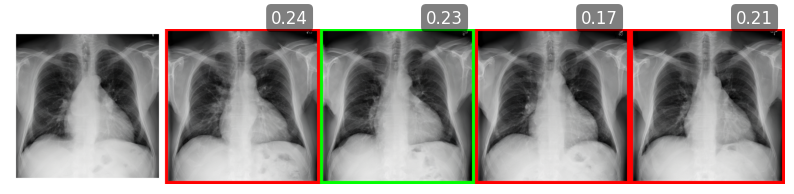

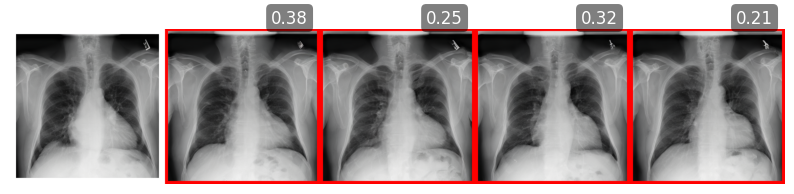

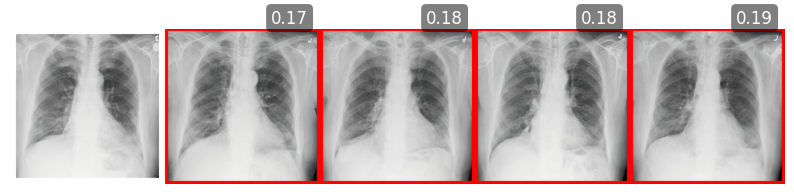

In [4]:
import torch
from einops import repeat
from src.dse import DiADMSampleEvaluator
# generate
N_PER_INDEX = 16
N_PER_CLASS = 15

device = torch.device("cuda")
dse = DiADMSampleEvaluator(device=device)
indices = []

# sample N_PER_CLASS images from each class
labels_per_class = torch.zeros(8) 
for i in range(len(train_ds)): 
    label = train_ds.label_list[i]
    if labels_per_class[label] < N_PER_CLASS: 
        labels_per_class[label] += 1
        indices.append(i)
    if labels_per_class.min() == N_PER_CLASS:
        break
indices = repeat(torch.tensor(indices), "l -> b l", b=N_PER_INDEX)
indices = indices.transpose(0, 1).flatten()

image_iter = ImageIterableDSE(train_ds=train_ds, 
                                  indices=indices, 
                                  device=device, 
                                  net=net, 
                                  sampler_fn=edm_sampler, 
                                  gnet=gnet, 
                                  encoder=encoder,
                                  outdir=outdir, 
                                  add_seed_to_path=False, 
                                  max_batch_size=N_PER_INDEX,
                                  dse=dse,
                                  sampler_kwargs={
                                    "autoguidance": default_kwargs[mode]["autoguidance"], 
                                    "guidance": default_kwargs[mode]["guidance"], 
                                  }
                              )

consinstency_scores = []
memorization_prediction = []
consistency_best = []
n_viz_samples = 3
for r in tqdm(image_iter, unit='batch', total=len(image_iter), desc=f"Generating images"):
    consinstency_scores.extend(r.consistency_score)
    consistency_best.append(torch.tensor(r.consistency_score).min().item())
    memorization_prediction.extend(r.memorization_prediction)
    if n_viz_samples: 
        name = r.paths[0].split("/")[1].split(".")[0] + "_gen_examples.pdf"
        viz_pred_with_border(torch.cat([r.real_image.unsqueeze(dim=0) ,r.images[:4]]), r.memorization_prediction, r.consistency_score, border_width=10, safe_name=f"{outdir}/{name}")
        n_viz_samples -= 1


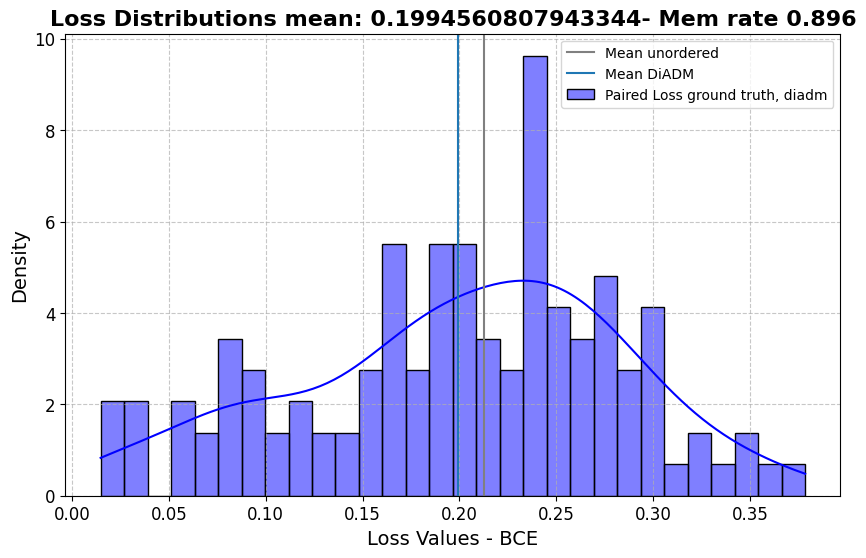

In [5]:
import seaborn as sns

# Set up the figure
plt.figure(figsize=(10, 6))  # Increased size for better visibility
# Plot histograms with predefined bins
sns.histplot(
    consistency_best, kde=True, label="Paired Loss ground truth, diadm", stat="density",
    bins=30, alpha=0.5, color="blue", edgecolor="black"
)

# Add gridlines
plt.grid(visible=True, linestyle="--", alpha=0.7)

# Labels and title with larger font size
plt.xlabel("Loss Values - BCE", fontsize=14)
plt.ylabel("Density", fontsize=14)
memorization_rate = torch.tensor(memorization_prediction).float().mean()
cons_mean = torch.tensor(consistency_best).mean()

plt.title(f"Loss Distributions mean: {cons_mean}- Mem rate {memorization_rate:.03f}", fontsize=16, fontweight="bold")

#plt.vlines([0.2129152932353318], 0, )
plt.axvline(0.2129152932353318, color="grey", label="Mean unordered")
plt.axvline(cons_mean, label="Mean DiADM")
# Adjust ticks for better visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

# Save the plot
plt.savefig(f"{outdir}/eval_diadm.pdf", bbox_inches="tight", dpi=300)

# Show the plot
plt.show()